In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Original CRS from input file:
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]

CRS Verification:
Input CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Output CRS in header: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]...


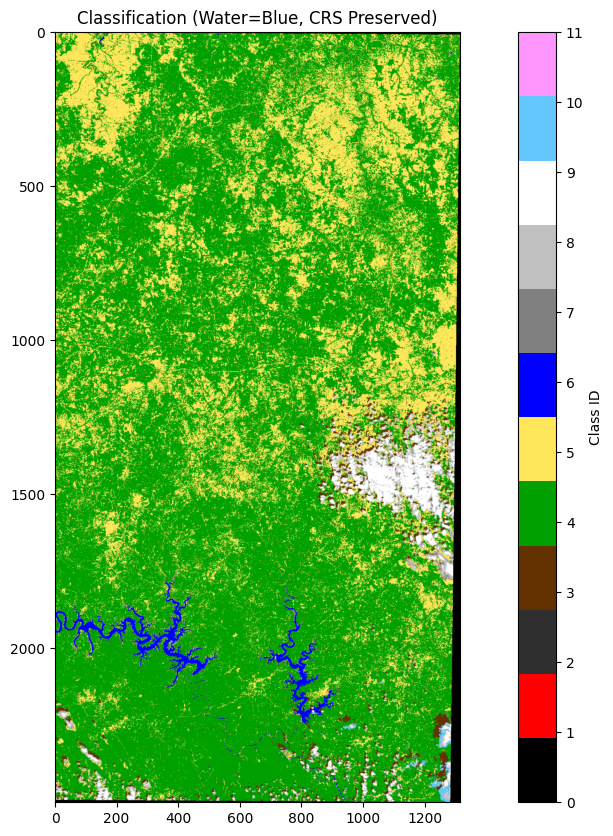


✅ Files created with EXACT original CRS:
→ /content/drive/MyDrive/Colab Notebooks/April2025_scene_classification.dat
→ /content/drive/MyDrive/Colab Notebooks/April2025_scene_classification.hdr


In [ ]:
from osgeo import gdal, osr
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# =============================================
# 1. PATHS (Update these)
# =============================================
input_path = "/content/drive/MyDrive/Colab Notebooks/2025-04-17-00_00_2025-04-17-23_59_Sentinel-2_L2A_Scene_classification_map.tiff"
output_dir = "/content/drive/MyDrive/Colab Notebooks"
output_base = os.path.join(output_dir, "April2025_scene_classification")

# =============================================
# 2. COORDINATE SYSTEM PRESERVATION
# =============================================
ds = gdal.Open(input_path)
original_crs = ds.GetProjectionRef()
geotransform = ds.GetGeoTransform()

print("Original CRS from input file:")
print(original_crs)

# =============================================
# 3. CLASSIFICATION WITH OFFICIAL COLORS
# =============================================
SCL_COLORS = {
    0: (0, 0, 0),
    1: (255, 0, 0),
    2: (47, 47, 47),
    3: (100, 50, 0),
    4: (0, 160, 0),
    5: (255, 230, 90),
    6: (0, 0, 255),
    7: (128, 128, 128),
    8: (192, 192, 192),
    9: (255, 255, 255),
    10: (100, 200, 255),
    11: (255, 150, 255)
}

r, g, b = [ds.GetRasterBand(i).ReadAsArray() for i in [1, 2, 3]]
rgb = np.stack([(r*255).astype('uint8'), (g*255).astype('uint8'), (b*255).astype('uint8')], axis=2)

class_image = np.zeros(r.shape, dtype='uint8')
tolerance = 2

for class_id, target_rgb in SCL_COLORS.items():
    mask = (
        (np.abs(rgb[...,0] - target_rgb[0]) <= tolerance) &
        (np.abs(rgb[...,1] - target_rgb[1]) <= tolerance) &
        (np.abs(rgb[...,2] - target_rgb[2]) <= tolerance)
    )
    if class_id == 6:
        class_image[mask] = 6
    elif class_id != 0:
        class_image[mask & (class_image == 0)] = class_id

class_image[(r == 0) & (g == 0) & (b == 0)] = 0

# =============================================
# 4. ENVI OUTPUT WITH CORRECT map info FOR GEOGRAPHIC CRS
# =============================================
output_dat = f"{output_base}.dat"
output_hdr = f"{output_base}.hdr"

with open(output_dat, 'wb') as f:
    class_image.tofile(f)

pixel_size_x = geotransform[1]
pixel_size_y = abs(geotransform[5])  # Make sure it's positive for the header

header = f"""ENVI
file type = ENVI Classification
samples = {ds.RasterXSize}
lines = {ds.RasterYSize}
bands = 1
header offset = 0
data type = 1
interleave = bsq
byte order = 0
map info = {{Geographic Lat/Lon, 1.0000, 1.0000, {geotransform[0]}, {geotransform[3]}, {pixel_size_x}, {pixel_size_y}, WGS-84, units=Degrees}}
coordinate system string = {{ {original_crs} }}

classes = 12
class lookup = {{
   {','.join(map(str, SCL_COLORS[0]))},
   {','.join(map(str, SCL_COLORS[1]))},
   {','.join(map(str, SCL_COLORS[2]))},
   {','.join(map(str, SCL_COLORS[3]))},
   {','.join(map(str, SCL_COLORS[4]))},
   {','.join(map(str, SCL_COLORS[5]))},
   {','.join(map(str, SCL_COLORS[6]))},
   {','.join(map(str, SCL_COLORS[7]))},
   {','.join(map(str, SCL_COLORS[8]))},
   {','.join(map(str, SCL_COLORS[9]))},
   {','.join(map(str, SCL_COLORS[10]))},
   {','.join(map(str, SCL_COLORS[11]))}}}
class names = {{
   No Data,
   Saturated or Defective,
   Dark Area Pixels,
   Cloud Shadows,
   Vegetation,
   Bare Soil,
   Water,
   Clouds (Low Probability),
   Clouds (Medium Probability),
   Clouds (High Probability),
   Cirrus,
   Snow}}
"""

with open(output_hdr, 'w') as f:
    f.write(header)

print("\nCRS Verification:")
print("Input CRS:", ds.GetProjectionRef())
print("Output CRS in header:", original_crs.split("\n")[0] + "...")

cmap = ListedColormap([np.array(SCL_COLORS[i])/255 for i in range(12)])
plt.figure(figsize=(15,10))
plt.imshow(class_image, cmap=cmap, vmin=0, vmax=11)
plt.colorbar(ticks=range(12), label="Class ID")
plt.title("Classification (Water=Blue, CRS Preserved)")
plt.show()

print(f"\n\u2705 Files created with EXACT original CRS:")
print(f"→ {output_dat}")
print(f"→ {output_hdr}")


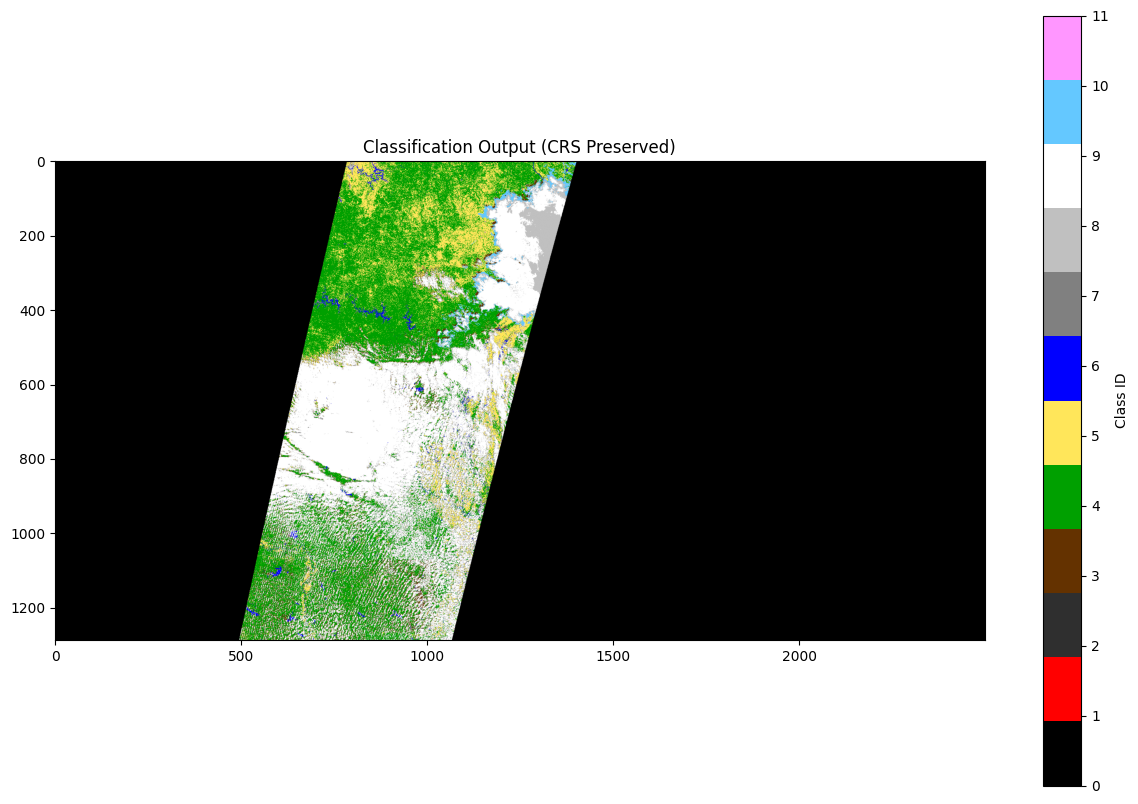

In [ ]:
from osgeo import gdal
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# =============================================
# 1. PATHS
# =============================================
input_path = "/content/drive/MyDrive/Colab Notebooks/2025-04-17-00_00_2025-04-17-23_59_Sentinel-2_L2A_Scene_classification_map.tiff"
output_dir = "/content/drive/MyDrive/Colab Notebooks"
output_base = os.path.join(output_dir, "SCL_FINAL_CORRECTED_CRS")

# =============================================
# 2. COORDINATE SYSTEM PRESERVATION
# =============================================
ds = gdal.Open(input_path)
original_crs = ds.GetProjectionRef()
geotransform = ds.GetGeoTransform()

# =============================================
# 3. CLASSIFICATION
# =============================================
SCL_COLORS = {
    0: (0, 0, 0), 1: (255, 0, 0), 2: (47, 47, 47), 3: (100, 50, 0),
    4: (0, 160, 0), 5: (255, 230, 90), 6: (0, 0, 255), 7: (128, 128, 128),
    8: (192, 192, 192), 9: (255, 255, 255), 10: (100, 200, 255), 11: (255, 150, 255)
}
r, g, b = [ds.GetRasterBand(i).ReadAsArray() for i in [1, 2, 3]]
rgb = np.stack([(r * 255).astype('uint8'), (g * 255).astype('uint8'), (b * 255).astype('uint8')], axis=2)

class_image = np.zeros(r.shape, dtype='uint8')
tolerance = 2
for class_id, target_rgb in SCL_COLORS.items():
    mask = (
        (np.abs(rgb[..., 0] - target_rgb[0]) <= tolerance) &
        (np.abs(rgb[..., 1] - target_rgb[1]) <= tolerance) &
        (np.abs(rgb[..., 2] - target_rgb[2]) <= tolerance)
    )
    if class_id == 6:
        class_image[mask] = 6
    elif class_id != 0:
        class_image[mask & (class_image == 0)] = class_id

class_image[(r == 0) & (g == 0) & (b == 0)] = 0

# =============================================
# 4. ENVI OUTPUT WITH CORRECTED CRS HEADER
# =============================================
output_dat = f"{output_base}.dat"
output_hdr = f"{output_base}.hdr"

with open(output_dat, 'wb') as f:
    class_image.tofile(f)

# WGS 84 EPSG:4326 resolution from screenshot
lat_res = 0.0033860
lon_res = 0.0042012

header = f"""ENVI
file type = ENVI Classification
samples = {ds.RasterXSize}
lines = {ds.RasterYSize}
bands = 1
header offset = 0
data type = 1
interleave = bsq
byte order = 0
map info = {{Geographic Lat/Lon, 1.0000, 1.0000, {geotransform[0]}, {geotransform[3]}, {lon_res}, {lat_res}, WGS-84, units=Degrees}}
coordinate system string = {{{original_crs}}}
classes = 12
class lookup = {{
   {','.join(map(str, SCL_COLORS[0]))},
   {','.join(map(str, SCL_COLORS[1]))},
   {','.join(map(str, SCL_COLORS[2]))},
   {','.join(map(str, SCL_COLORS[3]))},
   {','.join(map(str, SCL_COLORS[4]))},
   {','.join(map(str, SCL_COLORS[5]))},
   {','.join(map(str, SCL_COLORS[6]))},
   {','.join(map(str, SCL_COLORS[7]))},
   {','.join(map(str, SCL_COLORS[8]))},
   {','.join(map(str, SCL_COLORS[9]))},
   {','.join(map(str, SCL_COLORS[10]))},
   {','.join(map(str, SCL_COLORS[11]))}}}
class names = {{
   No Data,
   Saturated or Defective,
   Dark Area Pixels,
   Cloud Shadows,
   Vegetation,
   Bare Soil,
   Water,
   Clouds (Low Probability),
   Clouds (Medium Probability),
   Clouds (High Probability),
   Cirrus,
   Snow}}
"""

with open(output_hdr, 'w') as f:
    f.write(header)

# =============================================
# 5. PLOT
# =============================================
cmap = ListedColormap([np.array(SCL_COLORS[i])/255 for i in range(12)])
plt.figure(figsize=(15, 10))
plt.imshow(class_image, cmap=cmap, vmin=0, vmax=11)
plt.colorbar(ticks=range(12), label="Class ID")
plt.title("Classification Output (CRS Preserved)")
plt.show()
